In [14]:
%load_ext autoreload

%autoreload 2

In [15]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow.keras as tfk
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from validation.metrics import OME, MSE, get_CV_error
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from MODELS.ViscNN import load_models, create_ViscNN_concat, create_ViscNN_phys,predict_all_cv, ViscNN_concat_HP,  create_ViscNN_phys_HP
from validation.tests import custom_train_test_split, get_Mw_samples, crossval_NN, Mw_test, evaluate_model, crossval_compare, get_shear_samples, shear_test, get_temp_samples, Temp_test, assign_sample_ids
import keras_tuner as kt
from gpflow_tools.gpr_models import train_GPR, create_GPR
from data_tools.dim_red import fp_PCA
from data_tools.data_viz import val_epochs, calc_slopes_Mw, compare_cv
from data_tools.curve_fitting import *
from data_tools.SeabornFig2Grid import SeabornFig2Grid as sfg
import datetime
import keras.backend as K
import pickle
import random
from textwrap import wrap
pd.options.mode.chained_assignment = None  # default='warn'

In [4]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPUs


2022-05-19 16:23:19.325934: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-19 16:23:20.046144: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 25757 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:da:00.0, compute capability: 7.0


In [5]:
data = pd.read_excel('./Data/full_data_03_08_aug_MOD.xlsx', na_values = ['nan','','NaN'])
data.columns = [str(c) for c in data.columns]

In [6]:
OG_fp = []
for c in data.columns:
    if isinstance(c, str):
        if 'fp' in c:
            OG_fp.append(c)
len(OG_fp)

219

In [7]:
do_pca = False
if do_pca:
    data, fp_cols, pca = fp_PCA(data, 17, cols = OG_fp)
    cols = fp_cols + ['Mw', 'Temperature', 'Shear_Rate','Melt_Viscosity']
else:
    fp_cols = OG_fp
    cols = fp_cols + ['Mw', 'Temperature', 'Shear_Rate','Melt_Viscosity']

In [8]:
data.loc[data['Mw'] < 10, 'Mw'] = np.power(10, data.loc[data['Mw'] < 10, 'Mw'])
for c in ['Mw', 'Melt_Viscosity']:
    data[c] = np.log10(data[c])

data['PDI'].fillna(2)
data['ZERO_SHEAR'] = 1
data['SHEAR'] = 0
data['log_Shear_Rate'] = 0
for i in data.index:
    if data.loc[i, 'Shear_Rate'] != 0:
        data.loc[i,'log_Shear_Rate'] = np.log10(data.loc[i, 'Shear_Rate'])
        data.loc[i, 'SHEAR'] = 1
        data.loc[i, 'ZERO_SHEAR'] = 0
    if not data.loc[i,'PDI'] > 0:
        data.loc[i,'PDI'] = 2
    if data.loc[i,'PDI'] > 100:
        data.loc[i,'PDI'] = 2
        #data = data.drop([i])

In [9]:
load_data = False
custom = False
full_data = True
date = '2022-04-06'
data_type = 'split_custom_Mw_1187'


if full_data:
    train_df = data.sample(frac = 1)
    test_df = data.sample(frac = 1) #dummy df for compatibility
else:
    if load_data:
        train_df = pd.read_pickle(f'MODELS/{date}_{data_type}/train_data.pkl')
        if data_type == 'full':
            test_df = train_df#dummy df for compatibility
        elif data_type == 'full_aug':
            train_df = data.copy()
            test_df = train_df
        else:
            test_df = pd.read_pickle(f'MODELS/{date}_{data_type}/test_data.pkl')
    else: 
        if custom:
            total_samps = len(Mw_ids) + len(shear_ids)
            train_df, test_df = custom_train_test_split(filtered_data, test_id= random.sample(Mw_ids,total_samps//20) + random.sample(shear_ids,total_samps//20), id_col= 'SAMPLE_ID')
        else:
            train_df, test_df = train_test_split(filtered_data, test_size= 0.1)
        
        train_df = train_df.loc[:, (train_df != 0).any(axis=0)]
new_fp = []
for c in train_df.columns:
    if isinstance(c, str):
        if 'fp' in c:
            new_fp.append(c)

if len(OG_fp) != len(new_fp) and not load_data:
    test_df = test_df.drop(columns = list(set(OG_fp) - set(new_fp)))



print(len(train_df))
print(len(test_df))

1905
1905


In [10]:
logMw = np.array(train_df['Mw']).reshape((-1,1))
shear = np.array(train_df['Shear_Rate']).reshape((-1,1))
Temp = np.array(train_df['Temperature']).reshape((-1,1))
Temp = 1/(Temp+273.15)
PDI = np.array(train_df['PDI']).reshape((-1,1))

scaler = MinMaxScaler(copy = False)
XX = np.array(scaler.fit(train_df.filter(fp_cols)).transform(train_df.filter(fp_cols)))
yy = np.array(train_df.loc[:,'Melt_Viscosity']).reshape((-1,1))

y_scaler = MinMaxScaler().fit(yy)
yy = y_scaler.transform(yy);
T_scaler = MinMaxScaler().fit(Temp)
T = T_scaler.transform(Temp);
M_scaler = MinMaxScaler().fit(logMw)
M = M_scaler.transform(logMw);
S_trans = PowerTransformer(standardize = False).fit(shear)
S_scaler = MinMaxScaler().fit(S_trans.transform(shear))
S = S_scaler.transform(S_trans.transform(shear))
P_scaler = MinMaxScaler().fit(PDI)
P = P_scaler.transform(PDI)
#shear = S_scaler.transform((shear))
#gpr_Mcr, mcr_cv_error = Mcr_gpr_train(OG_fp, None, M_scaler, scaler, transform = False)

y_test = y_scaler.transform(np.array(test_df.loc[:,'Melt_Viscosity']).reshape((-1,1)))
X_test = np.array(scaler.transform(test_df.filter(fp_cols)))
M_test = M_scaler.transform(np.array(test_df['Mw']).reshape((-1,1)))
S_test = S_scaler.transform(S_trans.transform(np.array(test_df['Shear_Rate']).reshape((-1,1))))
T_test = np.array(test_df['Temperature']).reshape((-1,1))
T_test = T_scaler.transform(1/(T_test+273.15))
P_test = P_scaler.transform(np.array(test_df['PDI']).reshape((-1,1)))

In [11]:
#XX, X_test, yy, y_test, M, M_test, S, S_test, T, T_test, train_ind, test_ind = train_test_split(X_tot, Y_tot,logMw, shear, Temp, range(tot_samples), test_size= 0.1)

In [35]:
Mw_samps, mw_ids = get_Mw_samples(data.copy(), full = True);
shear_samps, shear_ids = get_shear_samples(data.copy(), full = True)
temp_samps, temp_ids = get_temp_samples(data.copy(), full = False)

/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [22]:
predicted_constants_Mw = pd.DataFrame(columns = ['Sample', 'a1', 'a2', 'k1', 'k2', 'Mcr'])
for mid in mw_ids:
    extrap_tests = Mw_test(Mw_samps, mid)
    XX_ex, OH, M_ex_og,S_ex_og,T_ex_og, P_ex_og = extrap_tests['data_in']
    log_visc_ex = extrap_tests['exp'][1][~np.isnan(np.power(10,extrap_tests['exp'][1]))]
    P_exp = extrap_tests['exp'][2][~np.isnan((extrap_tests['exp'][1]))]
    P_exp = P_scaler.transform(np.array(P_exp).reshape(-1,1))
    Mw_ex = extrap_tests['exp'][0][~np.isnan((extrap_tests['exp'][1]))]
    XX_ex = scaler.transform((XX_ex))
    M_ex = M_scaler.transform(M_ex_og)
    S_ex = S_scaler.transform(S_trans.transform(S_ex_og))
    T_ex = T_scaler.transform(1/(T_ex_og+273.15))
    P_ex = P_scaler.transform(P_ex_og)
    y_ax = (-2, 11)
    temps = [-50, -20, 20, 50]
    
    #print(XX_ex, M_ex, S_ex, T_ex, P_ex)
    # print(Mw_ex.astype(float).shape)
    # print(log_visc_ex.astype(float).shape)
    
    if Mw_ex.shape[0] > 4:
            a1, a2, k1, k2, Mcr = fit_Mw(np.array(Mw_ex).astype(float), np.array(log_visc_ex).astype(float))
            if a1 < 0 or a1 > 3:
                a1 = np.nan
            if a2 < 1.5 or a2 > 7:
                a2 = np.nan
            if Mcr < 1:
                Mcr = np.nan
            predicted_constants_Mw = pd.concat([predicted_constants_Mw, pd.DataFrame({'Sample': extrap_tests['sample'], 'a1': [a1], 'a2':[a2], 'k1':[k1], 'k2':[k2], 'Mcr':[Mcr]})], ignore_index= True)

  

/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ayush/Melt_Viscosity_Predictor/.venv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ayush/Melt

In [23]:
predicted_constants_Mw.groupby('Sample').head()

,Sample,a1,a2,k1,k2,Mcr
0,poly(prop-1-ene) at 200.0 C,NaN,2.299715,16.54518,-8.705708,NaN
1,polyisobutylene at 25.0 C,NaN,2.66722,28.61484,-6.390675,3.11135
2,Linear HDPE at 150.0 C,1.127386,3.711861,-4.325285,-13.603777,3.590088
3,polyisobutylene at 150.0 C,1.0,NaN,-3.157005,-3.157005,3.2
4,polyisobutylene at 150.0 C,1.0,3.463213,-3.663159,-13.434722,3.966998
5,polyisobutylene at 175.0 C,1.0,NaN,-3.467857,-3.467857,3.2
6,polyisobutylene at 175.0 C,1.0,3.152938,-47.923269,-12.291779,NaN
7,polyisobutylene at 200.0 C,1.0,NaN,-4.108248,-4.108248,3.2
8,polyisobutylene at 175.0 C,NaN,3.988801,-16.583881,-16.58388,6.639762
9,polyisobutylene at 100.0 C,1.0,NaN,-2.255432,-2.255432,3.285759


In [24]:
with open('Data/Mw_const_data.pickle', 'wb') as handle:
    pickle.dump(predicted_constants_Mw, handle)

In [ ]:
with open('Data/ann_pred_const_Mw1.pickle', 'wb') as handle:
    pickle.dump(predicted_constants_ann1, handle)

In [ ]:
predicted_constants_gpr = pd.read_pickle('Data/gpr_pred_const.pickle')
predicted_constants_ann = pd.read_pickle('Data/ann_pred_const.pickle')

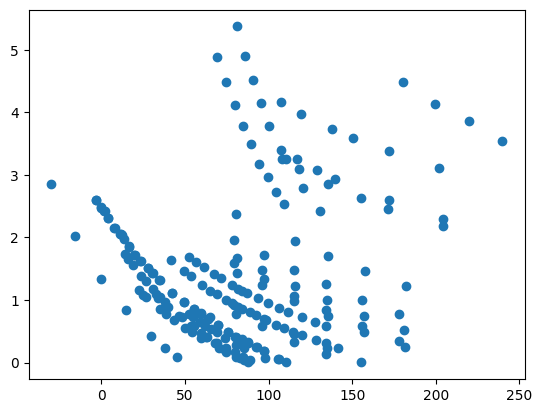

[ 0.         -0.34408602 -0.62365591 -0.94623656]
0    180.408163
1    199.591837
2    219.591837
3    239.591837
Name: Temperature, dtype: float64
[ 0.         -0.11585366 -0.18292683 -0.29573171 -0.44512195 -0.54268293
 -0.56707317 -0.73780488 -0.87804878 -0.9695122  -1.08231707 -1.17073171
 -1.2804878  -1.49085366 -1.63414634 -1.74390244 -1.82317073 -1.89939024
 -1.99390244 -2.10365854 -2.18902439 -2.23170732 -2.2804878  -2.35365854
 -2.40853659 -2.54268293]
0      -3.295867
1      -0.199180
2       1.602475
3       3.888270
4       7.625717
5      11.222331
6      12.564286
7      16.415217
8      19.725989
9      23.377159
10     27.934991
11     30.543570
12     34.755687
13     42.489810
14     49.524419
15     55.252367
16     59.517333
17     63.553741
18     69.618914
19     75.906604
20     80.165650
21     83.763183
22     87.434732
23     92.784066
24     97.261568
25    105.905208
Name: Temperature, dtype: float64
[ 0.         -0.18815331 -0.43205575 -0.56445993 -0.777003

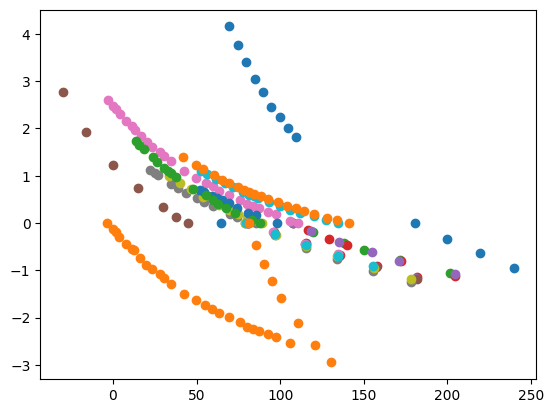

In [60]:
# Temperature WLF fitting for ANN
matplotlib.rc_file_defaults()
#predicted_constants_ann = pd.DataFrame(columns = ['Sample', 'a1', 'a2', 'k1', 'k2', 'Mcr'])
temp_constants = pd.DataFrame(columns = ['C1, C2, Tr'])
no_fit = 0
tot = 0
temp_samps = temp_samps.dropna(subset = ['Melt_Viscosity'])
plt.scatter(temp_samps['Temperature'], np.power(10, temp_samps['Melt_Viscosity']))
plt.show()
for tid in temp_ids:
    
    # extrap_tests = Mw_test(temp_samps, tid)
    # XX_ex, OH, M_ex_og,S_ex_og,T_ex_og, P_ex_og = extrap_tests['data_in']
    # log_visc_ex = extrap_tests['exp'][1][~np.isnan(np.power(10,extrap_tests['exp'][1]))]
    # Mw_ex = extrap_tests['exp'][0][~np.isnan((extrap_tests['exp'][1]))]
    # P_exp = extrap_tests['exp'][2][~np.isnan((extrap_tests['exp'][1]))]
    # P_exp = P_scaler.transform(np.array(P_exp).reshape(-1,1))
    # XX_ex = scaler.transform((XX_ex))
    # M_ex = M_scaler.transform(M_ex_og)
    # S_ex = S_scaler.transform(S_trans.transform(S_ex_og))
    # T_ex = T_scaler.transform(1/(T_ex_og+273.15))
    # P_ex = P_scaler.transform(P_ex_og)
    # y_ax = (-2, 11)
    # temps = np.linspace(-50, 50, 20)
    
    trial = pd.DataFrame(temp_samps.loc[temp_samps['SAMPLE_ID'] == tid]).reset_index(drop = True)
    trial['Melt_Viscosity'] = np.power(10, trial['Melt_Viscosity'])
    #print(trial['Melt_Viscosity'])
    a_T = [i - trial['Melt_Viscosity'][0] for i in trial['Melt_Viscosity']]
    print(np.array(a_T).reshape(-1,))
    print(trial['Temperature'])
    
    try:
        tot += 1
        Tr, C1, C2 = fit_WLF(np.array(trial['Temperature']).reshape(-1,), np.array(a_T).reshape(-1,), trial['Temperature'][0])
        temp_constants = pd.concat([temp_constants, pd.DataFrame({'Sample': tid, 'C1': [C1], 'C2':[C2], 'Tr':[Tr]})], ignore_index= True)
        plt.scatter(np.array(trial['Temperature']).reshape(-1,), np.array(a_T).reshape(-1,))
    except:
        no_fit += 1

print(no_fit)
print(tot)
    

In [61]:
temp_constants

,"C1, C2, Tr",Sample,C1,C2,Tr
0,NaN,3306.0,1.129271e+01,6.556286e+02,180.074594
1,NaN,3597.0,5.239798e+00,1.167218e+02,-2.877803
2,NaN,3598.0,3.552716e+00,2.272520e+02,107.179169
3,NaN,3599.0,3.570852e+00,2.156142e+02,107.416793
4,NaN,3600.0,3.434474e+00,2.123963e+02,107.709528
5,NaN,3615.0,3.201253e+00,1.619259e+02,44.975932
6,NaN,3819.0,-1.169033e+00,4.119851e-01,8.784026
7,NaN,3820.0,2.614673e+00,2.086629e+02,84.861089
8,NaN,3821.0,2.358215e+00,1.863904e+02,89.298316
9,NaN,3822.0,2.109597e+00,2.380265e+02,134.449656


In [62]:
with open('Data/temp_const_data.pickle', 'wb') as handle:
    pickle.dump(temp_constants, handle)


In [50]:
predicted_constants_shear = pd.DataFrame(columns = ['Sample', 'z_shear', 'n', 'tau'])
for sid in shear_ids:
    try:
        extrap_tests = shear_test(shear_samps, sid)
        XX_ex, M_ex_og,S_ex_og,T_ex_og, P_ex_og = extrap_tests['data_in']
        sample = extrap_tests['sample']
        log_visc_ex = extrap_tests['exp'][1][~np.isnan(np.power(10,extrap_tests['exp'][1]))]
        shear_exp = np.power(10,extrap_tests['exp'][0])[~np.isnan((extrap_tests['exp'][1]))]
        #print(shear_exp)
        P_exp = extrap_tests['exp'][2][~np.isnan((extrap_tests['exp'][1]))]
        P_exp = P_scaler.transform(np.array(P_exp).reshape(-1,1))
    except:
        print(f'Test failed for {sample}.')
        continue
    #The inputs for the ML model to predict
    XX_ex = scaler.transform((XX_ex))
    M_ex = M_scaler.transform(M_ex_og)
    S_ex = S_scaler.transform(S_trans.transform(S_ex_og))
    T_ex = T_scaler.transform(1/(T_ex_og+273.15))
    P_ex = P_scaler.transform(P_ex_og)
    temps = [-50, -20, 20, 50]

    try:
        if shear_exp.shape[0] >= 10:
            n_0, n, tau  = fit_shear((shear_exp).astype(float), log_visc_ex.astype(float))
            predicted_constants_shear = pd.concat([predicted_constants_shear, pd.DataFrame({'Sample': [sample], 'z_shear': [n_0], 'tau': [tau], 'n':[n]})], ignore_index = True)
    except:
        print(f'Could not fit sample {sample}')
    # a1, a2, k1, k2, Mcr = fit_Mw(np.array([a[0] for a in M_ex_og]).astype(float), np.array([a for a in test_pred]).astype(float))



/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-

Test failed for poly(epsilon-caprolactone) at 100.0 C, Mw = 16900.
Test failed for poly(epsilon-caprolactone) at 100.0 C, Mw = 16900.
Test failed for poly(epsilon-caprolactone) at 100.0 C, Mw = 16900.
Test failed for poly(epsilon-caprolactone) at 100.0 C, Mw = 16900.
Test failed for poly(epsilon-caprolactone) at 100.0 C, Mw = 16900.
Test failed for poly(epsilon-caprolactone) at 100.0 C, Mw = 16900.
Test failed for poly(epsilon-caprolactone) at 100.0 C, Mw = 16900.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly(11-aminoundecanoic acid) at 210.0 C, Mw = 29000.
Test failed for poly

/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample poly{[bis(4-fluorophenyl) 1,4-phenylene diketone]-alt-[2-phenyl-4,5-bis(4-hydroxyphenyl)imidazole]} at 300.0 C, Mw = 249999
Could not fit sample poly{[bis(4-fluorophenyl) 1,4-phenylene diketone]-alt-[2-phenyl-4,5-bis(4-hydroxyphenyl)imidazole]} at 320.0 C, Mw = 249999
Could not fit sample poly{[bis(4-fluorophenyl) 1,4-phenylene diketone]-alt-[2-phenyl-4,5-bis(4-hydroxyphenyl)imidazole]} at 350.0 C, Mw = 249999


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-

Could not fit sample poly[(bisphenol A)-co-epichlorohydrin] at 120.0 C, Mw = 1891


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-

Could not fit sample polyacrylonitrile, Poly(methyl acrylate) at 220.0 C, Mw = 31899


/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)
/home/ayush/Melt_Viscosity_Predictor/data_tools/curve_fitting.py:29: RuntimeWarning: invalid value encountered in log10
  V = np.log10(Z_S) - (1-n)*np.log10(1+ (Z_S/T)*S)


Could not fit sample Poly(hexano-6-lactam), PPTA at 260.0 C, Mw = 37075
Could not fit sample Poly(hexano-6-lactam), PPTA at 260.0 C, Mw = 37149


In [51]:
predicted_constants_shear

,Sample,z_shear,n,tau
0,"polystyrene at 200.0 C, Mw = 274685",1407.205493,0.634854,2047.883979
1,"polypropylene at 200.0 C, Mw = 236999",85902.168536,0.464116,57942.075987
2,"polypropylene at 200.0 C, Mw = 183000",41010.21018,0.562834,19214.136141
3,"poly(p-phenylene sulfide) at 300.0 C, Mw = 104000",50523.024812,0.731447,1297768.252205
4,"poly(p-phenylene sulfide) at 300.0 C, Mw = 64000",34650.713549,0.937156,0.028654
5,"Poly (butylene terephthalate) at 240.0 C, Mw ...",47031.95054,0.71109,0.168616
6,"Poly(hexano-6-lactam) at 260.0 C, Mw = 37000",955.292856,0.924498,0.0
7,"poly[(hexane-1,6-diamine)-alt-(adipic acid)] a...",1971.484145,0.804102,0.001737
8,"Poly(bisphenol A carbonate) at 200.0 C, Mw = 3...",1729999.609686,0.395677,35633250.568071
9,"poly([2-(phenylsulfonyl)hydroquinone]-alt-{4,4...",70567.181182,1.028777,11084.340591


In [49]:
with open('Data/shear_const_data.pickle', 'wb') as handle:
    pickle.dump(predicted_constants_shear, handle)



In [ ]:
shear_predicted_constants_gpr = pd.read_pickle('Data/shear_gpr_pred_const.pickle')
shear_predicted_constants_ann = pd.read_pickle('Data/shear_ann_pred_const.pickle')


Shear with Low and Zero Shear Rates

Holistic Model Performance